# Simulating regression results under noisy SEIR Model

This notebook evaluates the ability of our regression framework to obtain robust estimates for the impact of policy given the data available. Using a Monte Carlo approach, it simulates the outbreak progression using an SEIR model, allowing for noise in the $\beta$, $\gamma$, and $\sigma$ parameters, and allowing for $\beta$ to be affected by policy interventions. For each MC draw, it then uses our regression estimation framework to obtain estimates for the impact of those policies. We then compare the distribution of estimates with the true values, under various assumptions for the values of $\gamma$ and $\sigma$.

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from statsmodels.api import OLS, add_constant
import pandas as pd
import xarray as xr
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from codes import utils as cutil
from codes.models import epi
from codes.plotting import sims as simplot

sns.set(context="paper", style="white")

## Settings

In [504]:
# sim settings
n_days = 45
tsteps_per_day = 24
pop = 1e5
E0 = 1 / pop
I0 = 0
R0 = 0
n_samples = 1000
gamma_to_test = [0.05, 0.2, 0.33]
sigma_to_test = [0.2, 0.33, 0.5]
min_cases = 10
reg_to_run = ["I", "EI", "IR", "EIR"]
reg_lag_days = [0, 7]
policies_to_include = ["p1", "p2", "p3"]

# policy settings
no_policy_growth_rate = 0.4

p1_effect = -0.05
p1_lag = [0] * 7  # the effect of the lag for as many days until it reaches full effect
p1_day_st, p1_day_end = 10, 15

p2_effect = -0.1
p2_lag = [0.5] * 7
p2_day_st, p2_day_end = 15, 20

p3_effect = -0.2
p3_lag = [0.25] * 7
p3_day_st, p3_day_end = 20, 25

# stochasticity settings
beta_noise_on = True
beta_noise_sd = 0.08

gamma_noise_on = True
gamma_noise_sd = 0.08

sigma_noise_on = True
sigma_noise_sd = 0.08

# debug
# gamma_to_test = [.3]
# sigma_to_test = [0.3]
# n_samples = 100

## Run simulations

In [505]:
attrs = dict(
    n_days=n_days,
    tsteps_per_day=tsteps_per_day,
    pop=pop,
    E0=E0,
    I0=I0,
    R0=R0,
    n_samples=n_samples,
    min_cases=min_cases,
    no_policy_growth_rate=no_policy_growth_rate,
    p1_effect=p1_effect,
    p1_lag=p1_lag,
    p1_day_st=p1_day_st,
    p1_day_end=p1_day_end,
    p2_effect=p2_effect,
    p2_lag=p2_lag,
    p2_day_st=p2_day_st,
    p2_day_end=p2_day_end,
    p3_effect=p3_effect,
    p3_lag=p3_lag,
    p3_day_st=p3_day_st,
    p3_day_end=p3_day_end,
    beta_noise_on=beta_noise_on,
    gamma_noise_on=gamma_noise_on,
    sigma_noise_on=sigma_noise_on,
    beta_noise_sd=beta_noise_sd,
    gamma_noise_sd=gamma_noise_sd,
    sigma_noise_sd=sigma_noise_sd,
)

In [506]:
## Run simulation

# def run_sim_and_regression(pop, )

lags = [p1_lag, p2_lag, p3_lag]
# time
ttotal = n_days * tsteps_per_day + 1
t = np.linspace(0, 1, ttotal) * n_days

# initialize results array
estimates, S_min_p3, S_min = epi.init_reg_arrs(
    n_samples,
    len(reg_to_run),
    len(policies_to_include),
    len(gamma_to_test),
    len(sigma_to_test),
)

# get policy effects
policy_effects = np.array([p1_effect, p2_effect, p3_effect])
policy_dummies = epi.init_policy_dummies(
    policy_effects,
    [p1_day_st, p2_day_st, p3_day_st],
    [p1_day_end, p2_day_end, p3_day_end],
    lags,
    n_samples,
    ttotal,
    tsteps_per_day,
    seed=0,
)

n_samp_valid = policy_dummies.shape[0]
policy_effect_arr = (policy_dummies * policy_effects).sum(axis=2)

# get deterministic params
growth_rate_deterministic = np.ones(ttotal) * no_policy_growth_rate + policy_effect_arr
beta_deterministic = epi.get_beta_SEIR(
    growth_rate_deterministic, gamma_to_test, sigma_to_test
)

# get stochastic params
beta_stoch, gamma_stoch, sigma_stoch = epi.get_stochastic_params(
    beta_deterministic,
    beta_noise_sd,
    beta_noise_on,
    gamma_to_test,
    gamma_noise_sd,
    gamma_noise_on,
    sigma_to_test=sigma_to_test,
    sigma_noise_sd=sigma_noise_sd,
    sigma_noise_on=sigma_noise_on,
)

beta_stoch, gamma_stoch, sigma_stoch = epi.adjust_timescales_from_daily(
    tsteps_per_day, beta_stoch, gamma_stoch, sigma_stoch
)

# reshape to get in proper format for simulation function
beta_stoch = np.moveaxis(beta_stoch, 0, -1)
gamma_stoch = np.moveaxis(gamma_stoch, 0, -1)
sigma_stoch = np.moveaxis(sigma_stoch, 0, -1)

# run dynamic model
S, E, I, R = epi.run_SEIR(E0, I0, R0, beta_stoch, gamma_stoch, sigma_stoch)

# organize results
coords = OrderedDict(
    t=t,
    gamma=gamma_to_test,
    sigma=sigma_to_test,
    sample=range(n_samples),
    policy=policies_to_include,
)

res_ds = xr.Dataset(
    coords=coords,
    data_vars={
        "S": (("t", "gamma", "sigma", "sample"), S),
        "E": (("t", "gamma", "sigma", "sample"), E),
        "I": (("t", "gamma", "sigma", "sample"), I),
        "R": (("t", "gamma", "sigma", "sample"), R),
        "policies": (("t", "policy", "sample"), np.moveaxis(policy_dummies, 0, -1)),
    },
)

# add on other potentially observable quantities
res_ds["EI"] = res_ds["E"] + res_ds["I"]
res_ds["IR"] = res_ds["R"] + res_ds["I"]
res_ds["EIR"] = res_ds["EI"] + res_ds["R"]

# convert to daily observations
daily_ds = res_ds.sel(t=slice(0, None, tsteps_per_day))

# prep regression LHS vars (logdiff)
for this_val in reg_to_run:
    new = np.log(daily_ds[this_val]).diff(dim="t", n=1, label="lower").pad(t=(0, 1))
    new["t"] = daily_ds.t
    daily_ds[this_val + "_logdiff"] = new

# get minimum S for each simulation
# at end and when p3 turns on
S_min = daily_ds.S.isel(t=-1)
p3_on = (daily_ds.policies.sel(policy="p3") > 0).argmax(dim="t")
S_min_p3 = daily_ds.S.isel(t=p3_on)


## run regressions
estimates = np.empty(
    (
        len(gamma_to_test),
        len(sigma_to_test),
        n_samples,
        len(reg_to_run),
        len(policies_to_include) * len(reg_lag_days) + 1,
    ),
    dtype=np.float32,
)
estimates.fill(np.nan)

# add on lags
RHS_old = (daily_ds.policies>0).astype(int)
RHS_ds = RHS_old.drop_sel(policy=policies_to_include)
for l in reg_lag_days:
    lag_vars = RHS_old.shift(t=l, fill_value=0)
    lag_vars["policy"] = [f"{x}_lag{l}" for x in RHS_old.policy.values]
    RHS_ds = xr.concat((RHS_ds, lag_vars), dim="policy")

# Apply min cum_cases threshold used in regressions
valid_reg = daily_ds.I >= min_cases / pop

# only run regression if we have at least one "no-policy" day
no_pol_on_regday0 = (RHS_old > 0).max(dim="policy").argmax(dim="t") > valid_reg.argmax(
    dim="t"
)

for cx, case_var in enumerate(reg_to_run):
    print(f"Running regressions of {case_var}:")
    case_ds = daily_ds[case_var + "_logdiff"]
    for gx, g in enumerate(gamma_to_test):
        print(f"...gamma = {g}")
        g_ds = case_ds[:, gx]
        for sx, s in enumerate(sigma_to_test):
            print(f"......sigma = {s}")
            s_ds = g_ds[:, sx]
            for samp in range(n_samples):
                if no_pol_on_regday0[samp, gx, sx]:
                    this_valid = valid_reg[:, gx, sx, samp]
                    LHS = s_ds[:, samp][this_valid].values
                    RHS = add_constant(RHS_ds[:, :, samp][this_valid, :].values)
                    res = OLS(LHS, RHS, missing="drop").fit()
                    estimates[gx, sx, samp, cx] = res.params

params = OrderedDict(gamma=gamma_to_test, sigma=sigma_to_test)

estimates_ds = epi.res_arr_to_ds(
    estimates, reg_to_run, list(RHS_ds.policy.values), params, **attrs
)
estimates_ds["S_min"] = S_min
estimates_ds["S_min_p3"] = S_min_p3

/Users/ianbolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


Running regressions of I:
...gamma = 0.05
......sigma = 0.2
......sigma = 0.33
......sigma = 0.5
...gamma = 0.2
......sigma = 0.2
......sigma = 0.33
......sigma = 0.5
...gamma = 0.33
......sigma = 0.2
......sigma = 0.33
......sigma = 0.5
Running regressions of EI:
...gamma = 0.05
......sigma = 0.2
......sigma = 0.33
......sigma = 0.5
...gamma = 0.2
......sigma = 0.2
......sigma = 0.33
......sigma = 0.5
...gamma = 0.33
......sigma = 0.2
......sigma = 0.33
......sigma = 0.5
Running regressions of IR:
...gamma = 0.05
......sigma = 0.2
......sigma = 0.33
......sigma = 0.5
...gamma = 0.2
......sigma = 0.2
......sigma = 0.33
......sigma = 0.5
...gamma = 0.33
......sigma = 0.2
......sigma = 0.33
......sigma = 0.5
Running regressions of EIR:
...gamma = 0.05
......sigma = 0.2
......sigma = 0.33
......sigma = 0.5
...gamma = 0.2
......sigma = 0.2
......sigma = 0.33
......sigma = 0.5
...gamma = 0.33
......sigma = 0.2
......sigma = 0.33
......sigma = 0.5


In [507]:
save_fpath = cutil.HOME / "results" / "other" / f"seir_sim_estimates_pop_{int(pop)}.nc"
save_fpath.parent.mkdir(exist_ok=True, parents=True)
estimates_ds.to_netcdf(save_fpath)

## Regenerate predictions of cumulative cases under no-policy and policy scenarios

### True with-policy vals from simulation

In [508]:
true_pol = res_ds.EIR.isel(t=-1)

### True no-policy counterfactual

In [509]:
g_np_true = np.ones(ttotal) * no_policy_growth_rate
beta_np_true = epi.get_beta_SEIR(
    g_np_true, gamma_to_test, sigma_to_test
)
beta_np_true = beta_np_true[np.newaxis,...]
beta_np_true,gamma_np_true, sigma_np_true = epi.get_stochastic_params(
    beta_np_true,
    beta_noise_sd,
    False,
    gamma_to_test,
    gamma_noise_sd,
    False,
    sigma_to_test=sigma_to_test,
    sigma_noise_sd=sigma_noise_sd,
    sigma_noise_on=False,
)

beta_np_true, gamma_np_true, sigma_np_true = epi.adjust_timescales_from_daily(tsteps_per_day, beta_np_true,gamma_np_true, sigma_np_true)

# reshape to get in proper format for simulation function
beta_np_true = np.moveaxis(beta_np_true, 0, -1)
gamma_np_true = np.moveaxis(gamma_np_true, 0, -1)
sigma_np_true = np.moveaxis(sigma_np_true, 0, -1)

SEIR_np_true = epi.run_SEIR(E0, I0, R0, beta_np_true, gamma_np_true, sigma_np_true)
true_np = sum([i[-1] for i in SEIR_np_true[1:]])

# organize
coords = OrderedDict(
    gamma=true_pol.gamma,
    sigma=true_pol.sigma,
)
true_np = xr.DataArray(true_np.squeeze(), coords=coords, dims=coords.keys())

### Predicted with-policy using estimated growth rate impacts

In [510]:
def run_model_using_preds(growth_pred):
    # derive beta from estimated, gamma, sigma
    gamma_pred = np.array(gamma_to_test)[:,np.newaxis,np.newaxis,np.newaxis,np.newaxis]
    sigma_pred = np.array(sigma_to_test)[np.newaxis,:,np.newaxis,np.newaxis,np.newaxis]
    beta_pred = (growth_pred + gamma_pred) * (growth_pred + sigma_pred) / sigma_pred
    beta_pred = np.moveaxis(beta_pred,-1,0)
    gamma_pred =  np.moveaxis(gamma_pred,-1,0)
    sigma_pred =  np.moveaxis(sigma_pred,-1,0)

    gamma_pred = gamma_pred.repeat(beta_pred.shape[0],axis=0)
    sigma_pred = sigma_pred.repeat(beta_pred.shape[0],axis=0)

    beta_pred, gamma_pred, sigma_pred = epi.adjust_timescales_from_daily(tsteps_per_day, beta_pred, gamma_pred, sigma_pred)

    # rerun SEIR model
    SEIR_pred = epi.run_SEIR(E0, I0, R0, beta_pred, gamma_pred, sigma_pred)
    pred = sum([i[-1] for i in SEIR_pred[1:]])

    # organize
    coords = OrderedDict(
        gamma=true_pol.gamma,
        sigma=true_pol.sigma,
        case_type=reg_to_run,
        sample=true_pol.sample,
    )
    pred = xr.DataArray(pred, coords=coords, dims=coords.keys())
    return pred

In [511]:
# get exponential growth rate w/ policy
g_pred_no_pol = np.repeat(estimates_ds.Intercept.transpose("gamma","sigma","case_type","sample").values[...,np.newaxis],policy_dummies.shape[1], axis=-1)
g_pred = g_pred_no_pol.copy()
p_on = (policy_dummies>0).argmax(axis=1)
for px,p in enumerate(policies_to_include):
    for l in reg_lag_days:
        lvar = estimates_ds[p+"_lag"+str(l)].transpose('gamma','sigma','case_type','sample').values
        for s in range(policy_dummies.shape[0]):
            this_on = p_on[s,px]+ l*tsteps_per_day
            g_pred[:,:,:,s,this_on:] += lvar[:,:,:,s][...,np.newaxis]
            
pred_pol = run_model_using_preds(g_pred)

### Predicted counterfactual

In [512]:
pred_np = run_model_using_preds(g_pred_no_pol)

In [513]:
diffs = xr.Dataset({"true": true_np - true_pol})
diffs = diffs.merge((pred_np - pred_pol).to_dataset(dim="case_type"))
diffs.to_netcdf(cutil.HOME / "results" / "other" / f"seir_pred_estimates_pop_{int(pop)}.nc")

## Plot results

### Histograms of cases averted/delayed

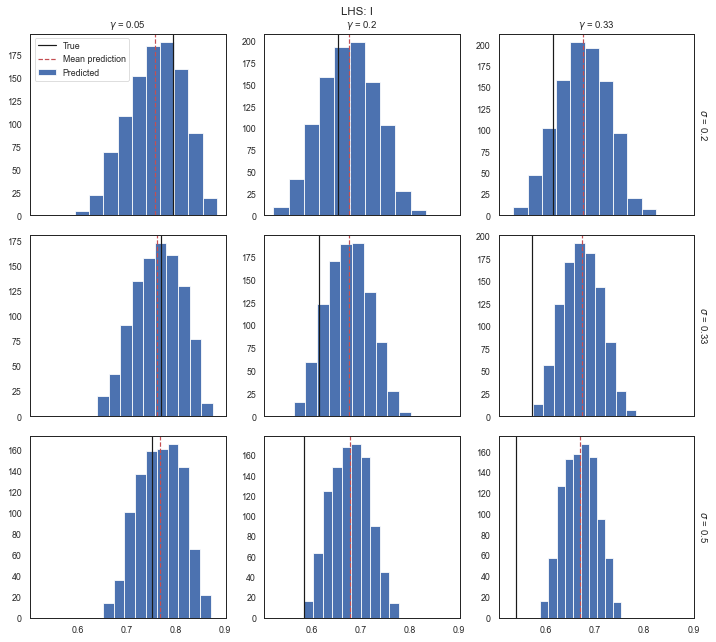

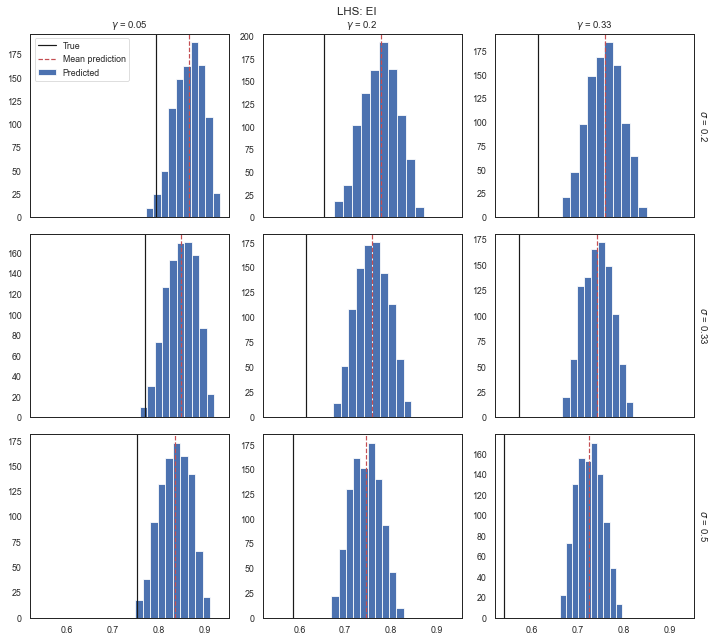

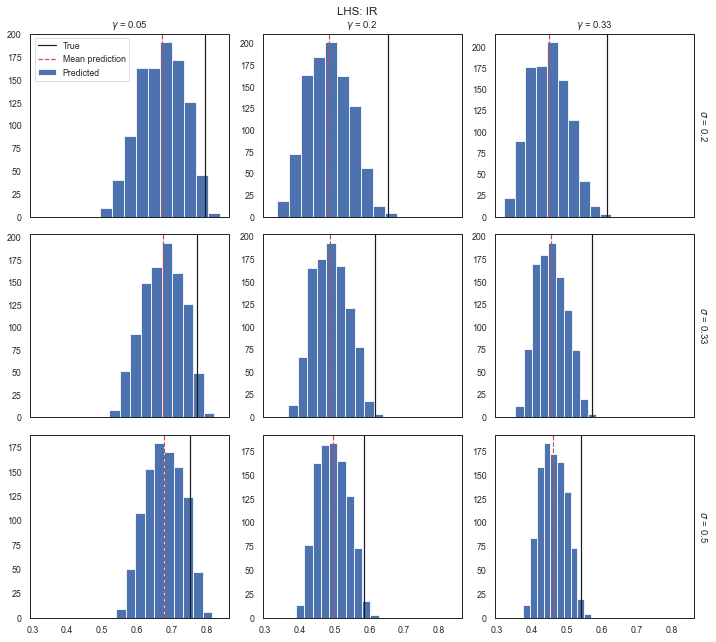

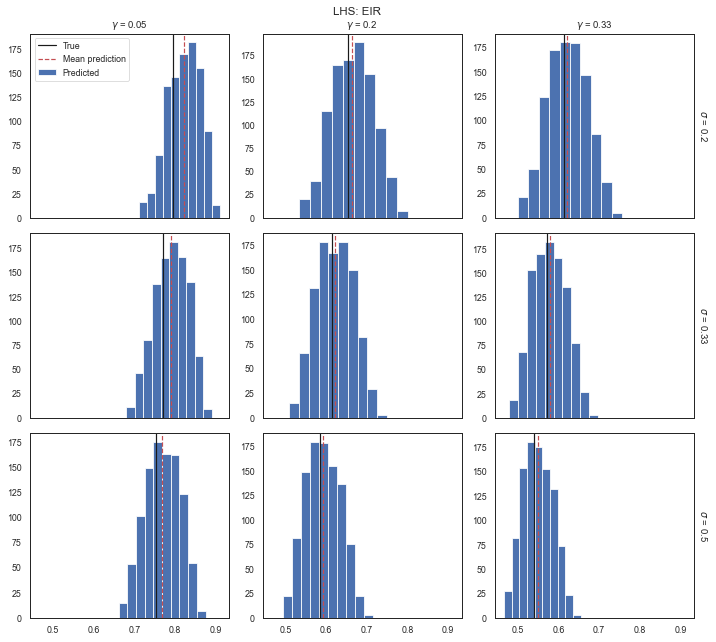

In [514]:
for i in reg_to_run:
    out_path = (
        out_dir
        / f"SEIR_sim_pred_results_{i}_betaNoise_{bn}_gammaNoise_{gn}_sigmaNoise_{sn}_"
            f"pop{int(pop)}_lag_{'-'.join([str(s) for s in reg_lag_days])}.pdf"
    )
    g = xr.plot.FacetGrid(diffs,col="gamma", row="sigma", sharex=True, sharey=False)
    g.map(plt.hist, i, label="Predicted")
    g.map(lambda x: plt.axvline(x.mean().item(), label="True", color="k"), "true")
    g.map(
        lambda x: plt.axvline(
            np.nanmean(x), color="r", linestyle="--", label="Mean prediction"
        ),
        i,
    )
    g.axes.flat[0].legend(loc="upper left")
    g.set_xlabels("")
    g.set_titles("$\{coord}$ = {value}")
    g.fig.suptitle(f"LHS: {i}", va="bottom", y=0.99)
    g.fig.savefig(out_path, dpi=300, tight_layout=True, bbox_inches="tight")

### Histograms of growth rate impacts

These plots show potential bias in our estiamted parameters: The "no-policy" growth rate and the effects on that growth rate of each policy.

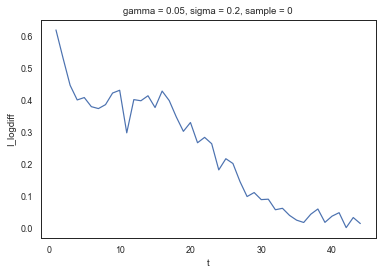

In [522]:
daily_ds.I_logdiff[:,0,0,0].plot()

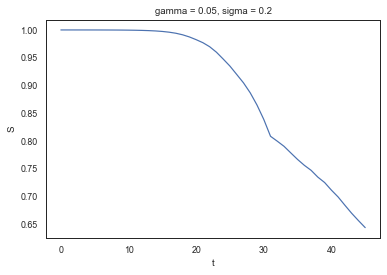

In [531]:
daily_ds.S[:,0,0,:].min(dim="sample").plot()

In [526]:
daily_ds.S

<xarray.DataArray 'S' (t: 46, gamma: 3, sigma: 3, sample: 1000)>
array([[[[0.99999   , 0.99999   , 0.99999   , ..., 0.99999   ,
          0.99999   , 0.99999   ],
         [0.99999   , 0.99999   , 0.99999   , ..., 0.99999   ,
          0.99999   , 0.99999   ],
         [0.99999   , 0.99999   , 0.99999   , ..., 0.99999   ,
          0.99999   , 0.99999   ]],

        [[0.99999   , 0.99999   , 0.99999   , ..., 0.99999   ,
          0.99999   , 0.99999   ],
         [0.99999   , 0.99999   , 0.99999   , ..., 0.99999   ,
          0.99999   , 0.99999   ],
         [0.99999   , 0.99999   , 0.99999   , ..., 0.99999   ,
          0.99999   , 0.99999   ]],

        [[0.99999   , 0.99999   , 0.99999   , ..., 0.99999   ,
          0.99999   , 0.99999   ],
         [0.99999   , 0.99999   , 0.99999   , ..., 0.99999   ,
          0.99999   , 0.99999   ],
         [0.99999   , 0.99999   , 0.99999   , ..., 0.99999   ,
          0.99999   , 0.99999   ]]],


       [[[0.99998886, 0.99998883, 0.9999887 , ..., 0.99998889,
          0.99998847, 0.99998876],
         [0.99998863, 0.99998861, 0.99998853, ..., 0.99998866,
          0.99998836, 0.99998856],
         [0.99998836, 0.99998836, 0.99998831, ..., 0.9999884 ,
          0.99998816, 0.99998832]],

        [[0.99998853, 0.99998849, 0.99998833, ..., 0.99998856,
          0.99998804, 0.99998839],
         [0.99998822, 0.9999882 , 0.99998811, ..., 0.99998826,
          0.99998789, 0.99998814],
         [0.99998787, 0.99998787, 0.99998781, ..., 0.99998792,
          0.99998763, 0.99998783]],

        [[0.99998827, 0.99998822, 0.99998804, ..., 0.99998831,
          0.99998769, 0.99998811],
         [0.99998791, 0.99998788, 0.99998777, ..., 0.99998795,
          0.99998751, 0.99998781],
         [0.99998749, 0.99998749, 0.99998741, ..., 0.99998754,
          0.9999872 , 0.99998744]]],


       [[[0.99998548, 0.99998523, 0.99998463, ..., 0.99998524,
          0.99998445, 0.99998498],
         [0.99998468, 0.99998456, 0.99998408, ..., 0.99998452,
          0.99998403, 0.99998431],
         [0.99998385, 0.99998381, 0.99998337, ..., 0.99998373,
          0.99998342, 0.99998353]],

        [[0.99998433, 0.99998401, 0.99998328, ..., 0.99998402,
          0.99998305, 0.99998375],
         [0.9999833 , 0.99998315, 0.99998259, ..., 0.9999831 ,
          0.99998248, 0.99998289],
         [0.99998222, 0.99998217, 0.99998168, ..., 0.99998208,
          0.99998167, 0.99998189]],

        [[0.99998351, 0.99998313, 0.99998228, ..., 0.99998313,
          0.99998203, 0.99998284],
         [0.99998231, 0.99998211, 0.99998147, ..., 0.99998206,
          0.99998135, 0.99998184],
         [0.99998103, 0.99998095, 0.99998041, ..., 0.99998086,
          0.99998038, 0.99998066]]],


       ...,


       [[[0.85498011, 0.78760838, 0.82529294, ..., 0.7755293 ,
          0.76247445, 0.73688553],
         [0.83525906, 0.77106029, 0.8101856 , ..., 0.7422989 ,
          0.73541399, 0.70995743],
         [0.81991973, 0.75628992, 0.79653739, ..., 0.71983665,
          0.71470752, 0.68883757]],

        [[0.74139451, 0.6392468 , 0.70050414, ..., 0.62896908,
          0.61004146, 0.57360764],
         [0.70456361, 0.6109194 , 0.6733105 , ..., 0.57810946,
          0.56927147, 0.5346065 ],
         [0.67804479, 0.58819693, 0.65130535, ..., 0.54788728,
          0.54199876, 0.50796237]],

        [[0.70346842, 0.59760541, 0.66061126, ..., 0.59109538,
          0.57144631, 0.53597406],
         [0.6645476 , 0.57136767, 0.63369343, ..., 0.54114821,
          0.53334657, 0.50135269],
         [0.63933351, 0.55291292, 0.61437266, ..., 0.51584765,
          0.5117796 , 0.48157225]]],


       [[[0.84799098, 0.77857214, 0.81747143, ..., 0.76690006,
          0.7524725 , 0.72622331],
         [0.82760309, 0.76151459, 0.80195019, ..., 0.73309771,
          0.72477208, 0.69874641],
         [0.81184474, 0.7464369 , 0.78799855, ..., 0.71044675,
          0.70375007, 0.67740144]],

        [[0.72961546, 0.6251855 , 0.6876312 , ..., 0.61478606,
  

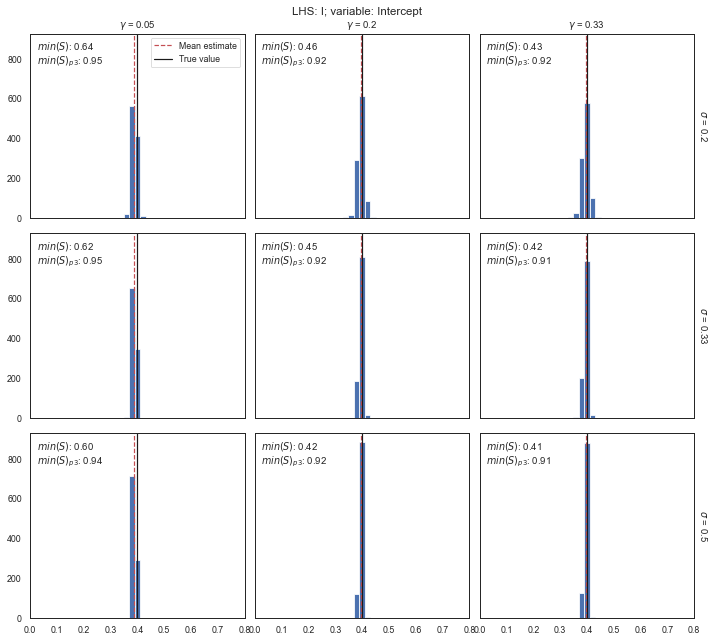

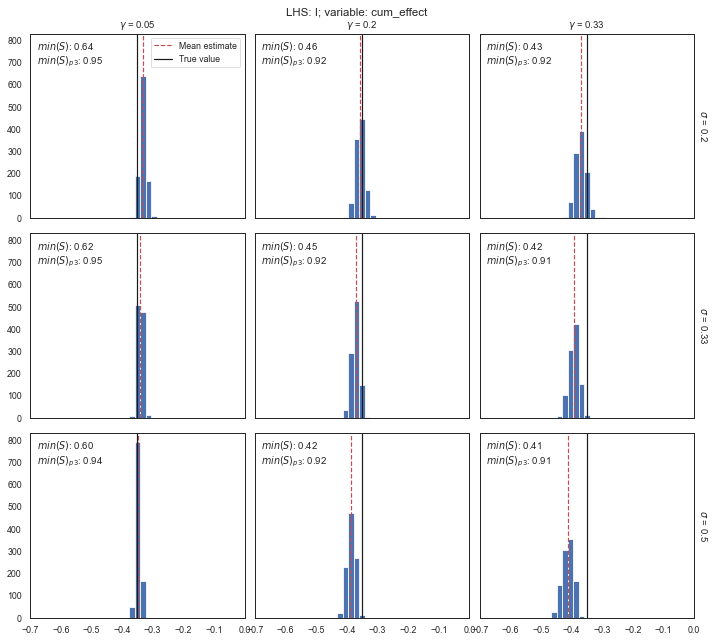

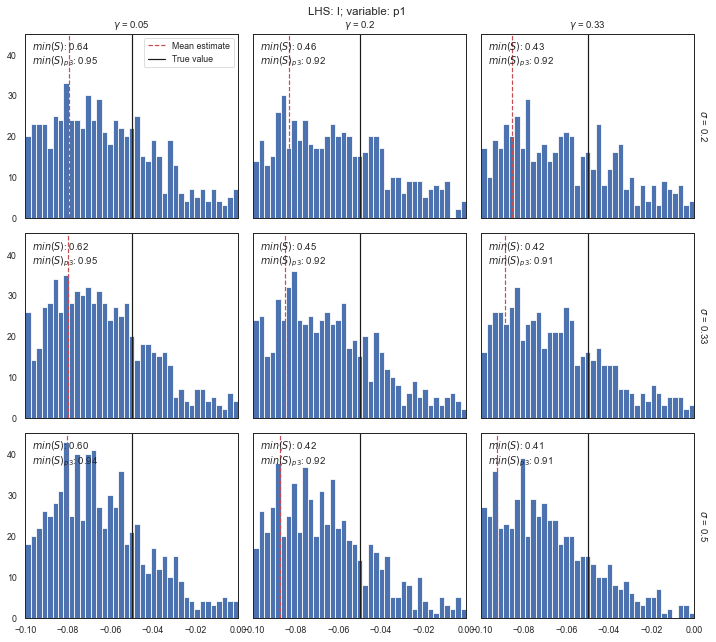

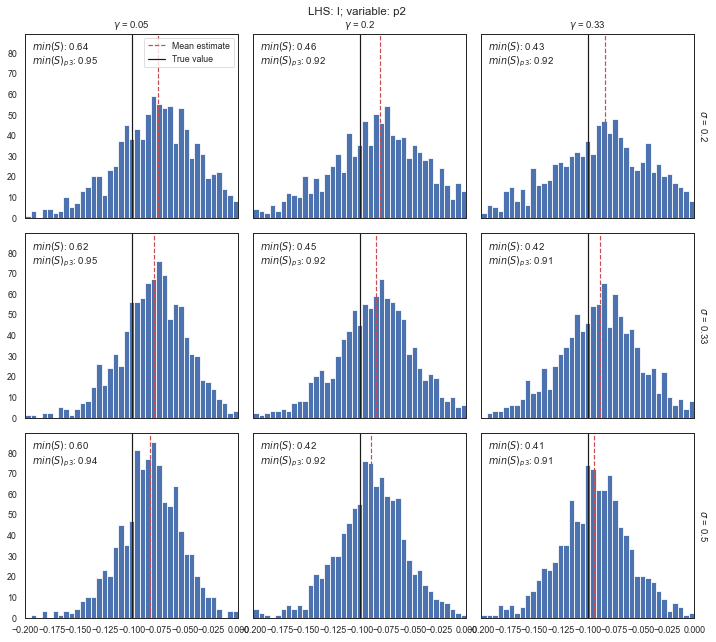

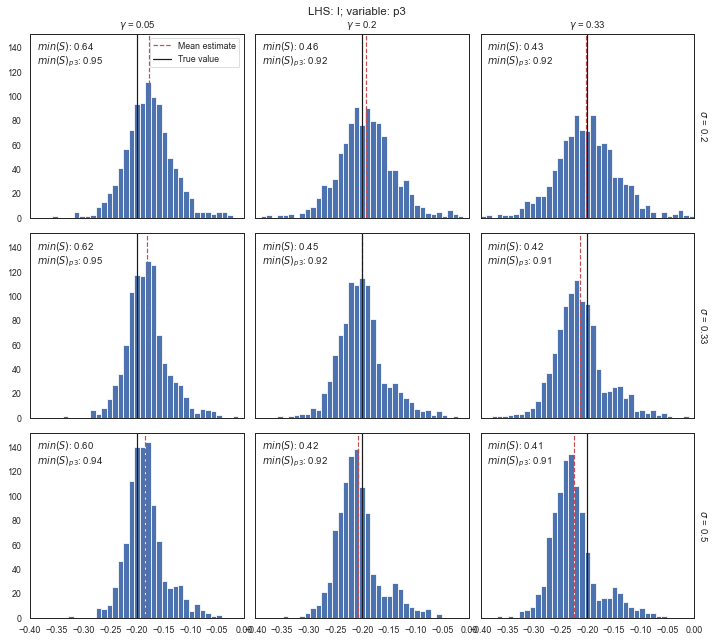

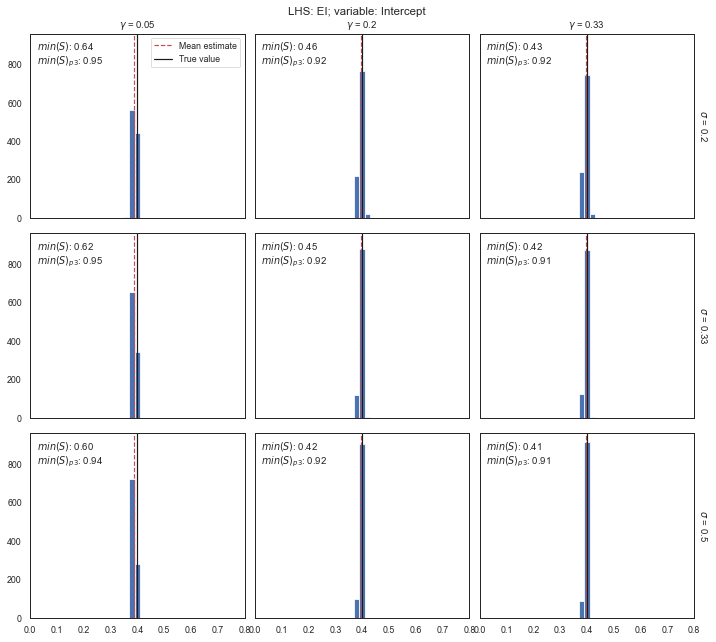

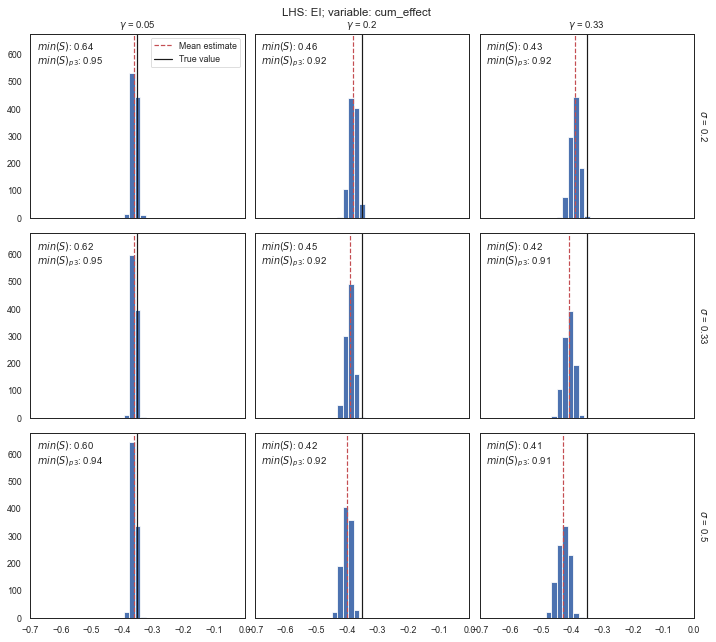

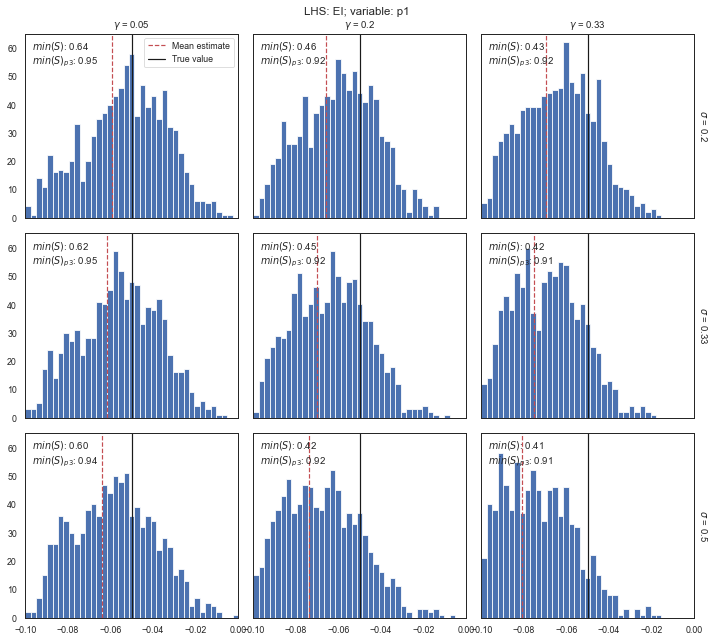

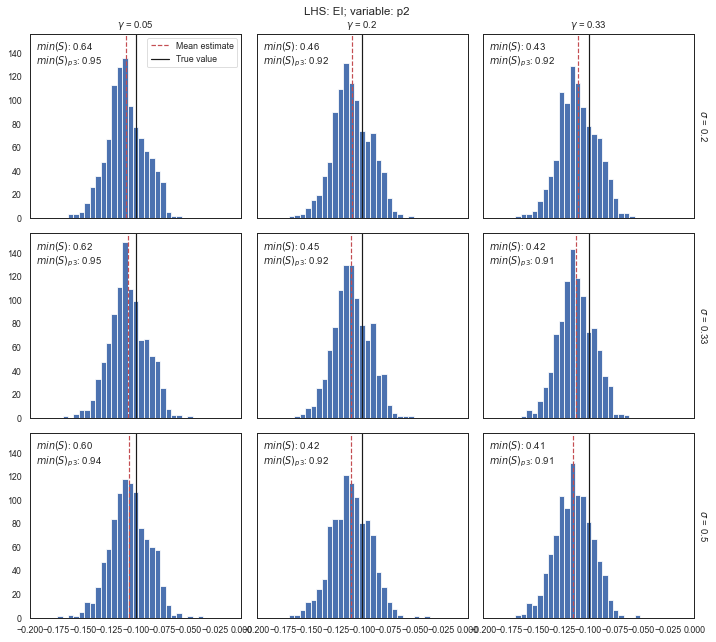

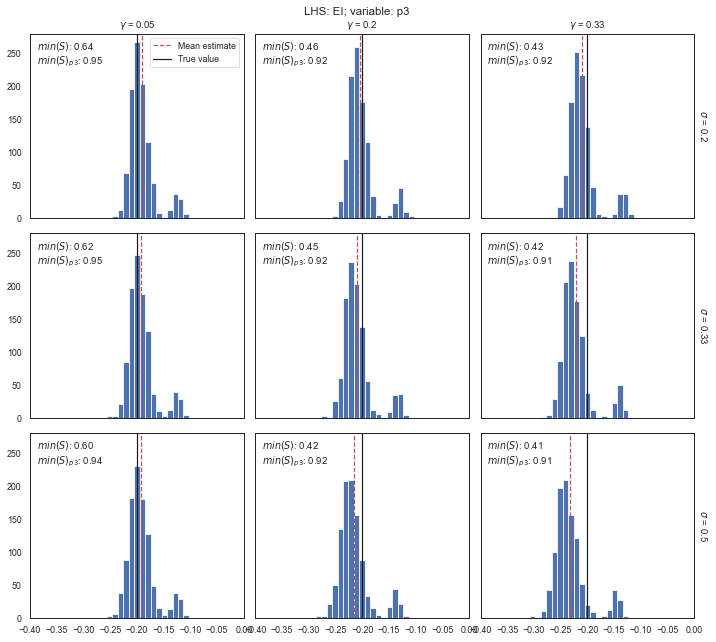

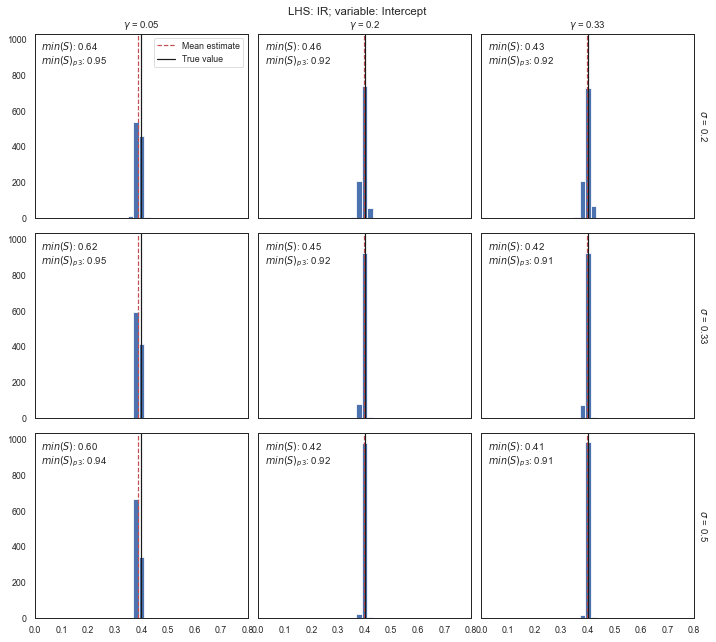

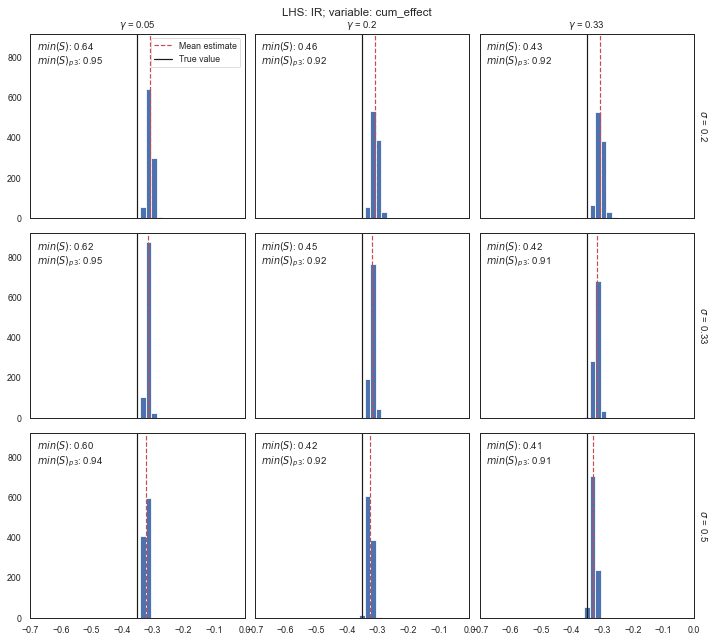

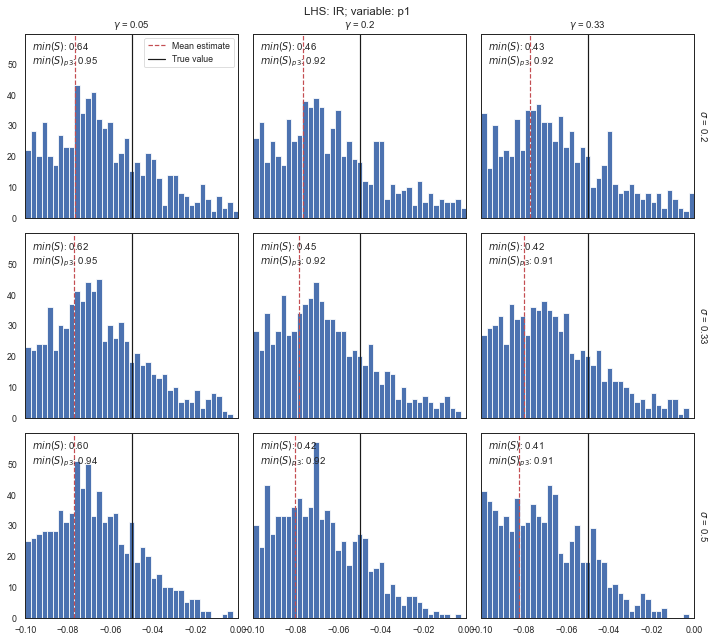

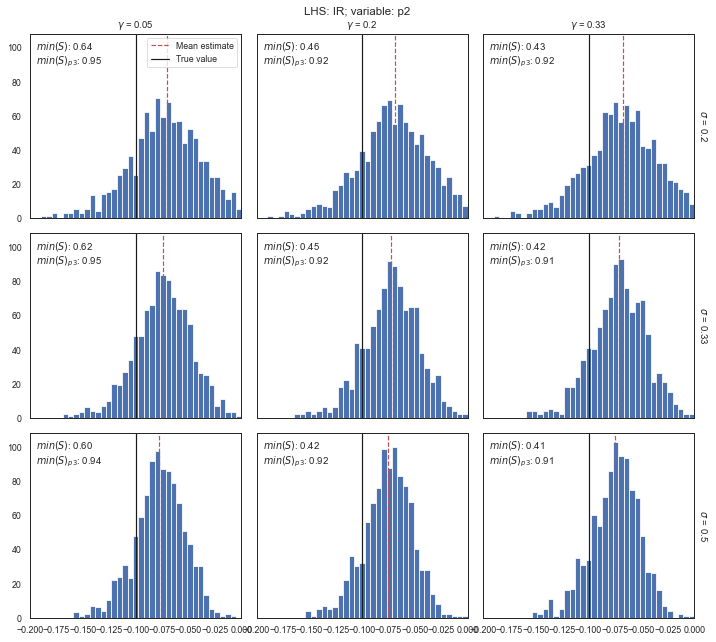

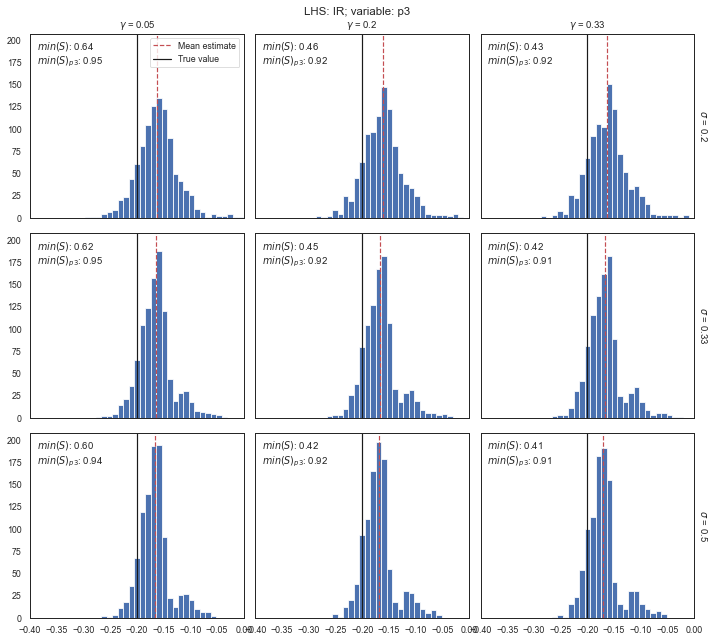

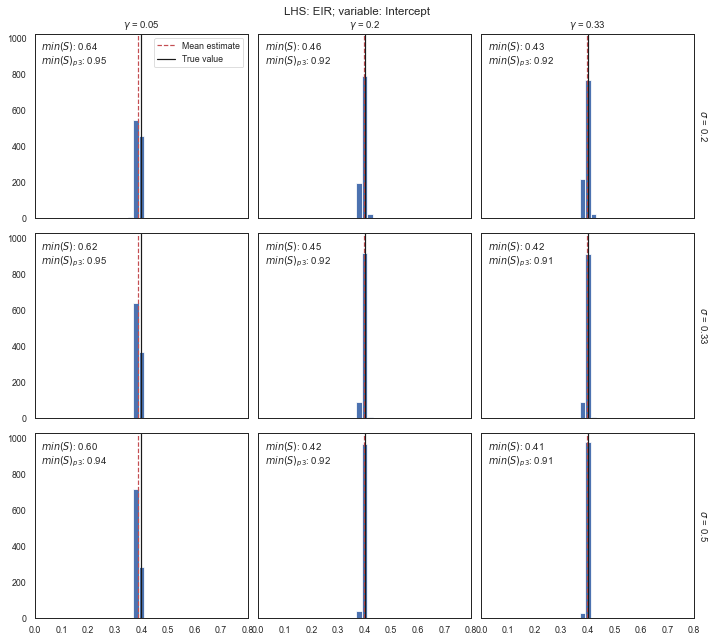

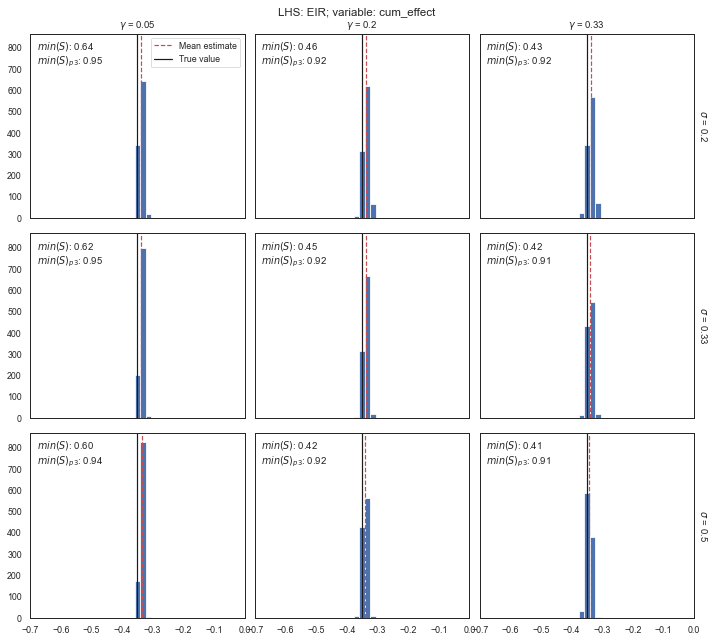

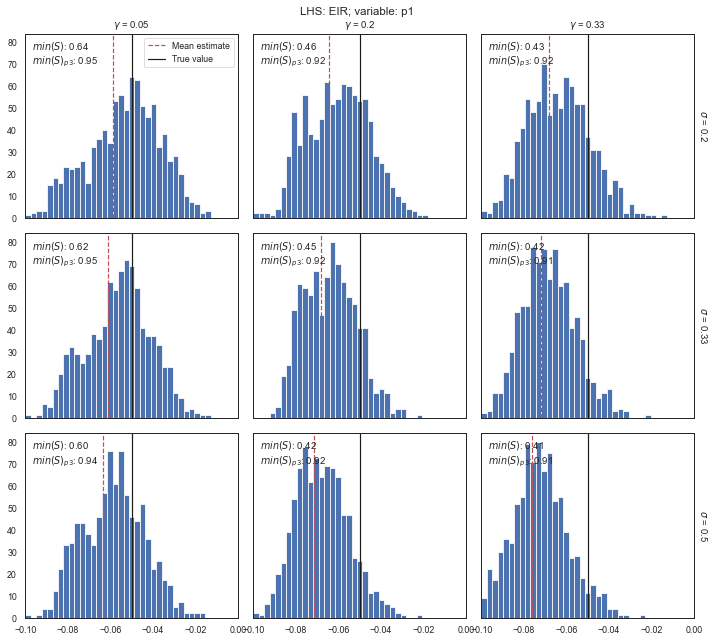

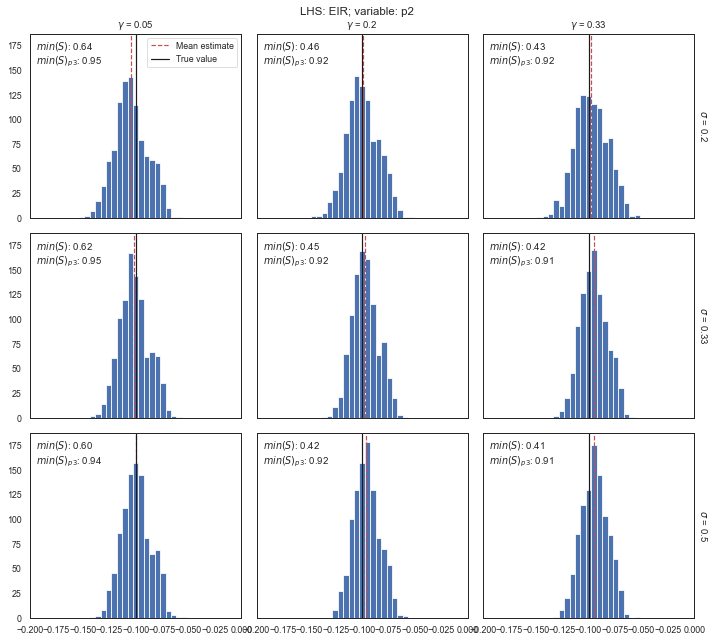

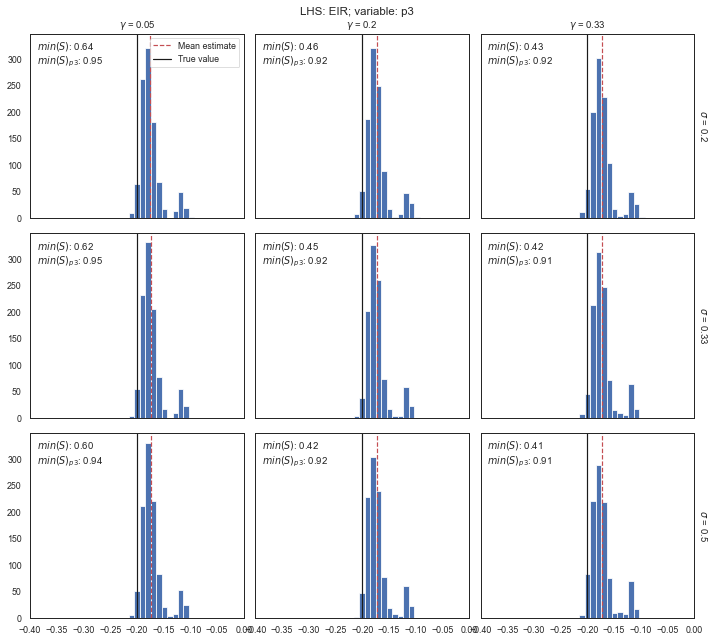

In [515]:
out_dir = cutil.HOME / "results" / "figures" / "sims"
out_dir.mkdir(parents=True, exist_ok=True)

# get cumulative impact of each policy, summing over lags
p = policies_to_include[0]
plot_list = []
for p in policies_to_include:
    this_da = (
        estimates_ds[[pol for pol in estimates_ds.data_vars if pol.startswith(p + "_")]]
        .to_array(dim=p)
        .sum(dim=p, skipna=False)
    )
    this_da.name = p
    plot_list.append(this_da)
plot_ds = xr.concat(plot_list, dim="variable")
plot_ds["variable"] = policies_to_include
plot_ds = plot_ds.to_dataset(dim="variable")
for i in ["Intercept", "S_min", "S_min_p3", "cum_effect"]:
    plot_ds[i] = estimates_ds[i]
plot_ds.attrs = estimates_ds.attrs

bn, gn, sn = (0, 0, 0)
if beta_noise_on:
    bn = beta_noise_sd
if gamma_noise_on:
    gn = gamma_noise_sd
if sigma_noise_on:
    sn = sigma_noise_sd

for c in estimates_ds.case_type.values:
    for v in ["Intercept", "cum_effect"] + policies_to_include:
        out_path = (
            out_dir
            / f"SEIR_sim_reg_results_{c}_{v}_betaNoise_{bn}_gammaNoise_{gn}_sigmaNoise_{sn}_"
                f"pop{int(pop)}_lag_{'-'.join([str(s) for s in reg_lag_days])}.pdf"
        )
        g = simplot.facet_hist(plot_ds, c, v, col="gamma", row="sigma")
        g.fig.savefig(out_path, dpi=300, tight_layout=True, bbox_inches="tight")

### Convergence of cumulative cases growth to active cases growth

These plots show how the growth rates in cumulative cases converge to the growth rates in active cases under a S ~= 1 regime (assuming no policy and no noise in $\gamma$).

In [514]:
this_pop = 5e3

In [515]:
this_E0 = 0 / this_pop
this_I0 = 1 / this_pop
this_R0 = 0 / this_pop

out = np.empty(
    (len(reg_to_run), len(gamma_to_test), len(sigma_to_test), ttotal), dtype=np.float32
)
out.fill(np.nan)
coords = OrderedDict(
    case_type=reg_to_run, gamma=gamma_to_test, sigma=sigma_to_test, t=t
)
res_da = xr.DataArray(coords=coords, dims=coords.keys(), data=out).to_dataset(
    dim="case_type"
)
for i in reg_to_run:
    res_da[i + "_logdiff"] = res_da[i].copy()
res_da["S"] = res_da["I"].copy()

# run sim
for gx, gamma in enumerate(gamma_to_test):
    for sx, sigma in enumerate(sigma_to_test):

        # get sample params
        this_beta = beta_deterministic[0, 0, gx, sx] * np.ones(ttotal) / tsteps_per_day
        this_gamma = gamma * np.ones(ttotal) / tsteps_per_day
        this_sigma = sigma * np.ones(ttotal) / tsteps_per_day

        # one policy to adjust to in the middle
        policy_on = int(ttotal / 2)
        beta_pol = beta_deterministic[0, -1, gx, sx] / tsteps_per_day
        this_beta[policy_on:] = beta_pol

        # run dynamic model
        S, E, I, R = epi.run_SEIR(
            ttotal, this_E0, this_I0, this_R0, this_beta, this_gamma, this_sigma
        )
        res_da["S"][gx, sx] = S
        res_da["I"][gx, sx] = I
        res_da["EI"][gx, sx] = I + E
        res_da["IR"][gx, sx] = I + R
        res_da["EIR"][gx, sx] = E + I + R

        for i in reg_to_run:
            a = res_da[i][gx, sx] * this_pop
            a = np.log(a).diff("t", 1)
            a["t"] = t[:-1]
            res_da[i + "_logdiff"][gx, sx, :-1] = a * tsteps_per_day
            res_da[i + "_logdiff"][gx, sx, -1] = np.nan

/Users/ianbolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


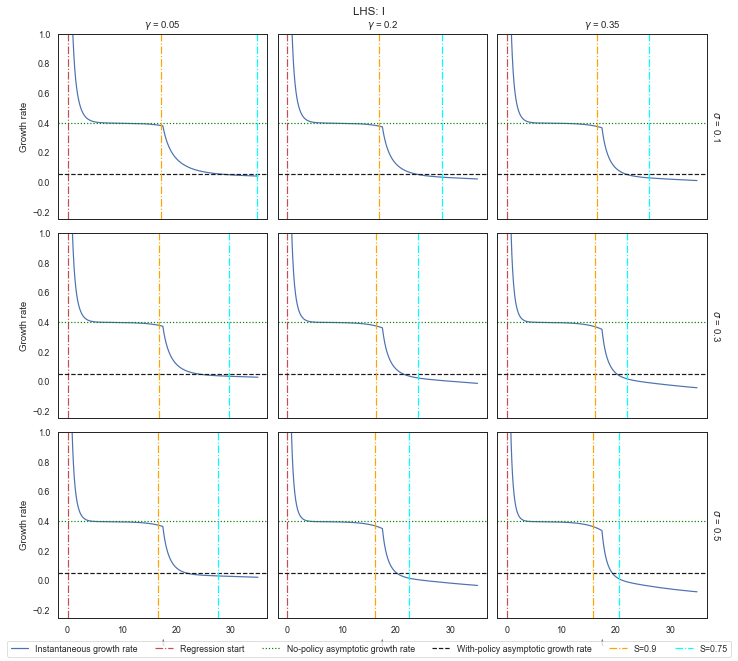

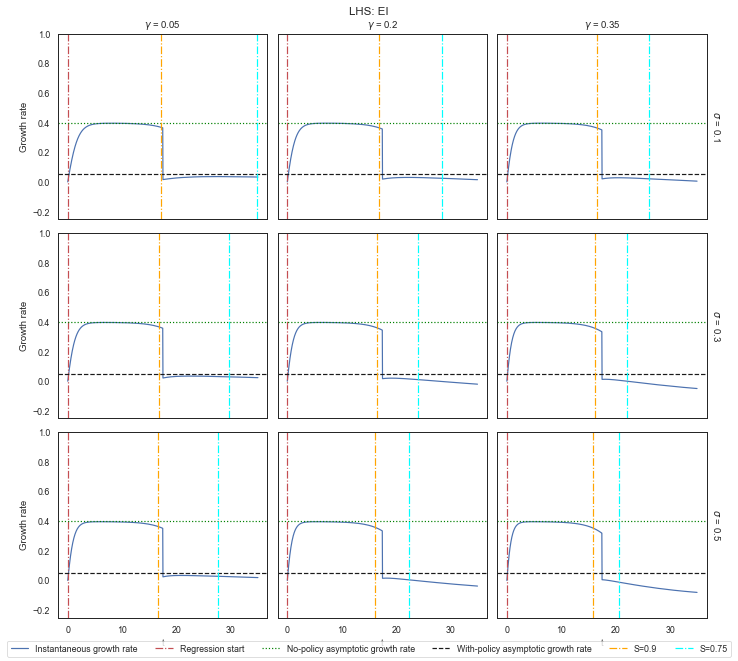

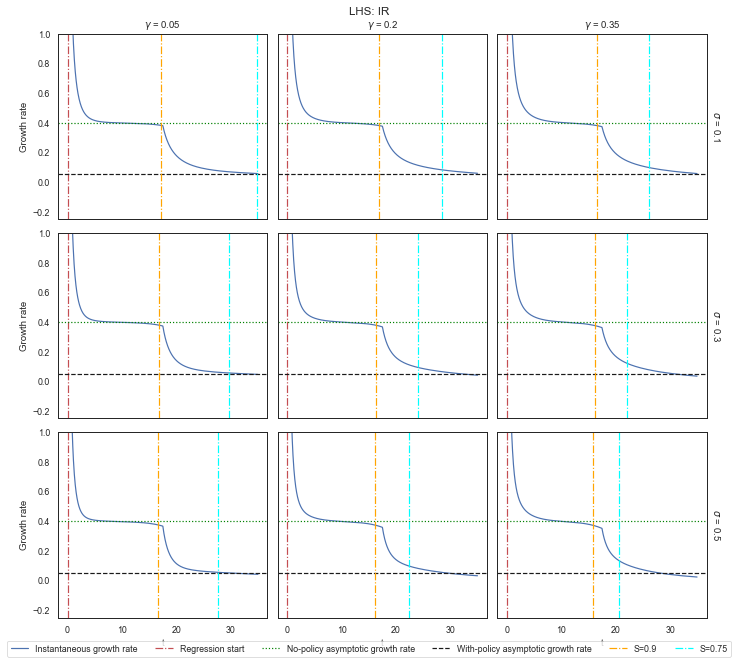

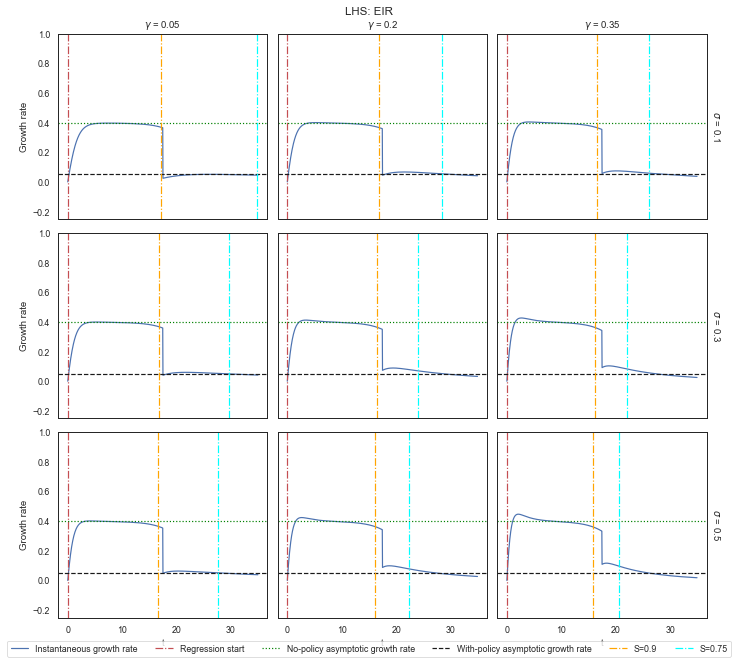

In [531]:
S_da = res_da.S
for case_type in reg_to_run:
    varname = case_type + "_logdiff"
    g = res_da[varname].plot(
        x="t",
        col="gamma",
        row="sigma",
        ylim=(-0.25, 1),
        label="Instantaneous growth rate",
    )
    for ax, namedict in zip(g.axes.flat, g.name_dicts.flat):
        casedata = res_da[case_type].loc[namedict]
        sdata = res_da.S.loc[namedict]
        ax.axvline(
            casedata.t[casedata >= (10 / pop)][0].item(),
            color="r",
            linestyle="-.",
            label="Regression start",
        )
        ax.axhline(
            no_policy_growth_rate,
            color="green",
            linestyle=":",
            label="No-policy asymptotic growth rate",
        )
        ax.axhline(
            no_policy_growth_rate + policy_effects.sum(),
            color="k",
            linestyle="--",
            label="With-policy asymptotic growth rate",
        )
        ax.axvline(
            sdata.t[sdata <= 0.9][0].item(),
            color="orange",
            linestyle="-.",
            label="S=0.9",
        )
        ax.axvline(
            sdata.t[sdata <= 0.75][0].item(),
            color="cyan",
            linestyle="-.",
            label="S=0.75",
        )
    g.fig.legend(
        *g.axes.flat[0].get_legend_handles_labels(), loc="lower center", ncol=6
    )
    g.set_titles("$\{coord}$ = {value}")
    g.set_ylabels("Growth rate")
    g.fig.suptitle(f"LHS: {case_type}", va="bottom", y=0.99)
    g.fig.savefig(
        out_dir / f"growth_sim_{case_type}_pop_{this_pop}.pdf",
        dpi=300,
        tight_layout=True,
    )